# <center>Using SQLite Upsert</center>

### Author:  Bryan Cafferky  - For Demonstration Purposes Only

### Not intended for production use. 

## Documentation at: https://docs.python.org/3/library/sqlite3.html

## Use SQLite Studio
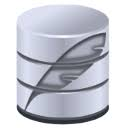

### 1)  Load the SQLite package...

In [70]:
import sqlite3

print(sqlite3.version)
print(sqlite3.sqlite_version)

import pandas as pd

2.6.0
3.37.0


## Danger!!! Danger!!! Will Robinson!  
## You Must have SQLite Version  3.24.0 (2018-06-04) or Higher

### 2) Connect to the database.  

In [71]:
conn = sqlite3.connect('aw.db') # permanent database

# Get Data from database management systems...

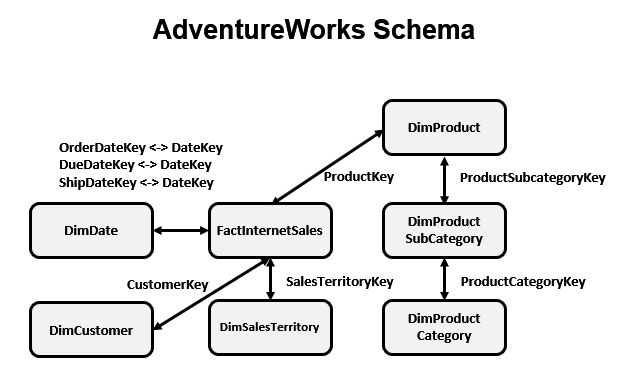

### We need to create the table with a primary key before saving data to it.
### The Primary Key uniquely identifies each row which we need so we can 
### tell SQLite which rows to Update or Delete.
### You cannot add a primary key to an existing table in SQLite!!!

In [72]:
conn.execute('DROP TABLE IF EXISTS customer')
conn.execute('DROP TABLE IF EXISTS cust_trans')

In [73]:
conn.execute('''
CREATE TABLE customer (
    CustomerKey   INTEGER PRIMARY KEY NOT NULL,
    LastName      TEXT,
    BirthDate     TEXT,
    MaritalStatus TEXT,
    YearlyIncome  REAL,
    ModifiedDate  TEXT,
    ETLLastUpdate DATETIME DEFAULT current_timestamp 
);
''')

### Querying meta data method 1 - using the sqlite_master table.

In [74]:
import pandas as pd

pd.read_sql_query("select name from sqlite_master where type = 'table'", conn)

name
0  customer

### Load the master table...

In [75]:
custdf = pd.read_csv("data/dimcustomer.csv", index_col = False)

In [76]:
custdf

customerkey lastname   birthdate maritalstatus  yearlyincome modifieddate
0        11000     Yang  1971-10-06             M       90000.0   2019-01-01
1        11001    Huang  1976-05-10             S       60000.0   2019-01-01
2        11002   Torres  1971-02-09             M       60000.0   2019-01-01
3        11003      Zhu  1973-08-14             S       70000.0   2019-01-01

### Save the dataframe to a table...

### Warning!!! Do not use if_exists='replace' or you will lose the primary key.  
### because the table gets dropped and created again!

In [77]:
custdf.to_sql('customer', conn, if_exists='append', index = False)

In [78]:
pd.read_sql_query("select * from customer", conn)

CustomerKey LastName   BirthDate MaritalStatus  YearlyIncome ModifiedDate  \
0        11000     Yang  1971-10-06             M       90000.0   2019-01-01   
1        11001    Huang  1976-05-10             S       60000.0   2019-01-01   
2        11002   Torres  1971-02-09             M       60000.0   2019-01-01   
3        11003      Zhu  1973-08-14             S       70000.0   2019-01-01   

         ETLLastUpdate  
0  2022-05-28 19:19:56  
1  2022-05-28 19:19:56  
2  2022-05-28 19:19:56  
3  2022-05-28 19:19:56

#### Getting meta data - Method 2: PRAGMA...

In [79]:
# Get table schema...
import pandas as pd 

pd.read_sql_query("""
PRAGMA table_info('customer');
""", conn)

cid           name      type  notnull         dflt_value  pk
0    0    CustomerKey   INTEGER        1               None   1
1    1       LastName      TEXT        0               None   0
2    2      BirthDate      TEXT        0               None   0
3    3  MaritalStatus      TEXT        0               None   0
4    4   YearlyIncome      REAL        0               None   0
5    5   ModifiedDate      TEXT        0               None   0
6    6  ETLLastUpdate  DATETIME        0  current_timestamp   0

### Lets load the transaction file...

In [80]:
transdf = pd.read_csv("data/dimcustomertransactions.csv", index_col = None)
transdf

customerkey lastname   birthdate maritalstatus  yearlyincome actionind  \
0        11000     Yang  1971-10-06             M      250000.0         U   
1        11001    Jones  1976-05-10             S      360000.0         U   
2       333301   Murhpy  1975-02-09             M       33000.0         A   
3       333302     Jain  1980-01-09             M       28000.0         A   
4        11002   Torres  1971-02-09             M       60000.0         D   

  modifieddate  
0   2020-01-01  
1   2019-02-01  
2   2018-01-01  
3   2020-02-01  
4   2020-02-01

In [81]:
transdf.to_sql('cust_trans', conn, if_exists='replace', index = False)
pd.read_sql_query("select * from cust_trans", conn)

customerkey lastname   birthdate maritalstatus  yearlyincome actionind  \
0        11000     Yang  1971-10-06             M      250000.0         U   
1        11001    Jones  1976-05-10             S      360000.0         U   
2       333301   Murhpy  1975-02-09             M       33000.0         A   
3       333302     Jain  1980-01-09             M       28000.0         A   
4        11002   Torres  1971-02-09             M       60000.0         D   

  modifieddate  
0   2020-01-01  
1   2019-02-01  
2   2018-01-01  
3   2020-02-01  
4   2020-02-01

### Let's update the customer table with the transactions.
- Add    - If the customer is not found, insert transaction as new customer.
- Change - If the customer is found, update the existing customer with the transaction data.
- Delete - If the actionind = 'D', remove the customer row. 

#### Note:  You must supply column names to allow the ETLLastUpdate to Default...

_____

## Using SQLite's Upsert!

### You can use SQLite Studio to test the Upsert statement!

#### Notice we do not update BirthDate.

### Upserting from a transaction table...
### Watch out for the WHERE true condition that SHOULD NOT BE NEEDED!!!

In [84]:
sql = '''
INSERT INTO customer(CustomerKey, LastName, BirthDate, MaritalStatus, YearlyIncome, ModifiedDate)
  SELECT CustomerKey, LastName, BirthDate, MaritalStatus, YearlyIncome, ModifiedDate 
  FROM cust_trans 
  WHERE true 
  ON CONFLICT(CustomerKey) 
  DO UPDATE SET 
    LastName=excluded.LastName,
    MaritalStatus=excluded.MaritalStatus,
    YearlyIncome = excluded.YearlyIncome, 
    ModifiedDate = excluded.ModifiedDate,
    ETLLastUpdate = current_timestamp
  WHERE excluded.ModifiedDate > customer.ModifiedDate
--  AND excluded.ActionInd in ('A', 'U');
'''
print(sql)


INSERT INTO customer(CustomerKey, LastName, BirthDate, MaritalStatus, YearlyIncome, ModifiedDate)
  SELECT CustomerKey, LastName, BirthDate, MaritalStatus, YearlyIncome, ModifiedDate 
  FROM cust_trans 
  WHERE true 
  ON CONFLICT(CustomerKey) 
  DO UPDATE SET 
    LastName=excluded.LastName,
    MaritalStatus=excluded.MaritalStatus,
    YearlyIncome = excluded.YearlyIncome, 
    ModifiedDate = excluded.ModifiedDate,
    ETLLastUpdate = current_timestamp
  WHERE excluded.ModifiedDate > customer.ModifiedDate
--  AND excluded.ActionInd in ('A', 'U');



In [85]:
conn.execute(sql)

In [86]:
pd.read_sql_query("select * from cust_trans", conn)

customerkey lastname   birthdate maritalstatus  yearlyincome actionind  \
0        11000     Yang  1971-10-06             M      250000.0         U   
1        11001    Jones  1976-05-10             S      360000.0         U   
2       333301   Murhpy  1975-02-09             M       33000.0         A   
3       333302     Jain  1980-01-09             M       28000.0         A   
4        11002   Torres  1971-02-09             M       60000.0         D   

  modifieddate  
0   2020-01-01  
1   2019-02-01  
2   2018-01-01  
3   2020-02-01  
4   2020-02-01

In [87]:
pd.read_sql_query("SELECT * FROM customer", conn)

CustomerKey LastName   BirthDate MaritalStatus  YearlyIncome ModifiedDate  \
0        11000     Yang  1971-10-06             M      250000.0   2020-01-01   
1        11001    Jones  1976-05-10             S      360000.0   2019-02-01   
2        11002   Torres  1971-02-09             M       60000.0   2020-02-01   
3        11003      Zhu  1973-08-14             S       70000.0   2019-01-01   
4       333301   Murhpy  1975-02-09             M       33000.0   2018-01-01   
5       333302     Jain  1980-01-09             M       28000.0   2020-02-01   

         ETLLastUpdate  
0  2022-05-28 19:31:21  
1  2022-05-28 19:31:21  
2  2022-05-28 19:31:21  
3  2022-05-28 19:19:56  
4  2022-05-28 19:31:21  
5  2022-05-28 19:31:21

In [88]:
# Delete
conn.execute('''DELETE FROM customer  
                WHERE CustomerKey IN (
                SELECT CustomerKey 
                FROM cust_trans where ActionInd = 'D');''')

pd.read_sql_query("select * from customer", conn)

CustomerKey LastName   BirthDate MaritalStatus  YearlyIncome ModifiedDate  \
0        11000     Yang  1971-10-06             M      250000.0   2020-01-01   
1        11001    Jones  1976-05-10             S      360000.0   2019-02-01   
2        11003      Zhu  1973-08-14             S       70000.0   2019-01-01   
3       333301   Murhpy  1975-02-09             M       33000.0   2018-01-01   
4       333302     Jain  1980-01-09             M       28000.0   2020-02-01   

         ETLLastUpdate  
0  2022-05-28 19:31:21  
1  2022-05-28 19:31:21  
2  2022-05-28 19:19:56  
3  2022-05-28 19:31:21  
4  2022-05-28 19:31:21

In [89]:
pd.read_sql_query("select * from cust_trans where ActionInd = 'D'", conn)

customerkey lastname   birthdate maritalstatus  yearlyincome actionind  \
0        11002   Torres  1971-02-09             M       60000.0         D   

  modifieddate  
0   2020-02-01

# Let's close the connection. 

In [90]:
conn.close()